In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
    AdaBoostRegressor,
    BaggingRegressor,
)
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import pycaret.regression as pyr


In [3]:
pubg_duoDF_ori: pd.DataFrame = pd.read_pickle("./DataFrame/pubg_duoDF.pkl")
pubg_duo_fppDF_ori: pd.DataFrame = pd.read_pickle("./DataFrame/pubg_duo_fppDF.pkl")


In [4]:
drop_features_low_connection = [
    "killPoints",
    "kills",
    "maxPlace",
    # "numGroups",
    "rideDistance",
    "roadKills",
    "swimDistance",
    "vehicleDestroys",
]


In [5]:
pubg_duoDF = pubg_duoDF_ori.drop(drop_features_low_connection, axis=1)
pubg_duo_fppDF = pubg_duo_fppDF_ori.drop(drop_features_low_connection, axis=1)


In [16]:
pubg_duoDF.corr()["winPlacePerc"].sort_values(ascending=False)


winPlacePerc       1.000000
walkDistance       0.823122
boosts             0.646184
weaponsAcquired    0.627273
damageDealt        0.470270
heals              0.444117
longestKill        0.409913
killStreaks        0.403929
DBNOs              0.353330
assists            0.326466
headshotKills      0.288519
revives            0.252894
winRankPoints      0.197391
teamKills          0.021557
numGroups          0.017087
matchDuration      0.000153
killPlace         -0.747252
Name: winPlacePerc, dtype: float64

In [7]:
weaponsAcquired_mask = pubg_duoDF["weaponsAcquired"] < 25
weaponsAcquired_mask_fpp = pubg_duo_fppDF["weaponsAcquired"] < 25


In [8]:
pubg_duoDF_sample = pubg_duoDF[weaponsAcquired_mask].sample(n=12500)
pubg_duo_fppDF_sample = pubg_duo_fppDF[weaponsAcquired_mask_fpp].sample(n=12500)


In [9]:
featureDF = pubg_duoDF_sample.drop(["winPlacePerc"], axis=1)
targetSR = pubg_duoDF_sample["winPlacePerc"]

featureDF_fpp = pubg_duo_fppDF_sample.drop(["winPlacePerc"], axis=1)
targetSR_fpp = pubg_duo_fppDF_sample["winPlacePerc"]


In [22]:
featureDF.iloc[0].tolist()


[0.0,
 2.0,
 202.7,
 1.0,
 0.0,
 1.0,
 60.0,
 0.0,
 0.0,
 1931.0,
 45.0,
 1.0,
 0.0,
 940.6,
 8.0,
 1510.0]

In [23]:
featureDF_fpp.iloc[0].tolist()


[2.0,
 5.0,
 608.3,
 3.0,
 0.0,
 7.0,
 4.0,
 1.0,
 100.7,
 1256.0,
 43.0,
 1.0,
 0.0,
 3951.0,
 4.0,
 1701.0]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    featureDF, targetSR, test_size=0.2, random_state=42
)
X_train_fpp, X_test_fpp, y_train_fpp, y_test_fpp = train_test_split(
    featureDF_fpp, targetSR_fpp, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train_fpp.shape, y_train_fpp.shape, X_test_fpp.shape, y_test_fpp.shape)


(10000, 16) (10000,) (2500, 16) (2500,)
(10000, 16) (10000,) (2500, 16) (2500,)


In [24]:
model = LGBMRegressor()
params = {
    "boosting_type": ("gbdt", "dart", "rf"),
    "num_leaves": (11, 31, 51, 71, 91),
    "max_depth": (10, 20, 30, -1),
    "n_estimators": (100, 200, 300),
    "class_weight": ("balanced", None),
}


In [25]:
gs = GridSearchCV(model, params)
gs.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1497
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 16
[LightGBM] [Info] Start training from score 0.500522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 16
[LightGBM] [Info] Start training from score 0.500381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

KeyboardInterrupt: 

In [ ]:
gs_fpp = GridSearchCV(model, params)
gs_fpp.fit(X_train_fpp, y_train_fpp)


In [11]:
scalers = []
scalers.append(StandardScaler())
scalers.append(MinMaxScaler())
scalers.append(RobustScaler())


In [12]:
models = []
models.append(LinearRegression())
models.append(Lasso())
models.append(Ridge())
models.append(KNeighborsRegressor())
models.append(DecisionTreeRegressor())
models.append(RandomForestRegressor())
models.append(ExtraTreesRegressor())
models.append(GradientBoostingRegressor())
models.append(SGDRegressor())
models.append(SVR())
models.append(LinearSVR())
models.append(LGBMRegressor())
models.append(XGBRegressor())


In [13]:
def find_model(models, X_train, X_test, y_train, y_test):
    scoreDict = {}
    i = 0
    for scaler in scalers:
        for model in models:
            scaler.fit(X_train)
            scaled_X_train = scaler.transform(X_train)
            scale_X_test = scaler.transform(X_test)
            model.fit(scaled_X_train, y_train)
            train_score = model.score(scaled_X_train, y_train)
            test_score = model.score(scale_X_test, y_test)
            score_diff = abs(test_score - train_score)
            train_mae = mean_absolute_error(y_train, model.predict(scaled_X_train))
            test_mae = mean_absolute_error(y_test, model.predict(scale_X_test))
            mae_diff = abs(test_mae - train_mae)
            scoreDict[i] = {
                "scaler": scaler,
                "model": model.__class__.__name__,
                "train_score": train_score,
                "test_score": test_score,
                "score_diff": score_diff,
                "train_mae": train_mae,
                "test_mae": test_mae,
                "mae_diff": mae_diff,
            }
            i += 1
    return pd.DataFrame(scoreDict).T


In [14]:
scoreDF = find_model(models, X_train, X_test, y_train, y_test)
score_fppDF = find_model(models, X_train_fpp, X_test_fpp, y_train_fpp, y_test_fpp)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1509
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 16
[LightGBM] [Info] Start training from score 0.483538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 16
[LightGBM] [Info] Start training from score 0.483538


KeyboardInterrupt: 

In [ ]:
scoreDF.sort_values(
    by=["test_mae", "mae_diff", "score_diff"], ascending=[True, True, True]
)


,scaler,model,train_score,test_score,score_diff,train_mae,test_mae,mae_diff
37,RobustScaler(),LGBMRegressor,0.95555,0.927852,0.027698,0.047587,0.057002,0.009416
11,StandardScaler(),LGBMRegressor,0.955631,0.927636,0.027995,0.047571,0.057008,0.009437
24,MinMaxScaler(),LGBMRegressor,0.95605,0.927147,0.028903,0.047456,0.057177,0.009721
19,MinMaxScaler(),ExtraTreesRegressor,1.0,0.925691,0.074309,0.0,0.057401,0.057401
6,StandardScaler(),ExtraTreesRegressor,1.0,0.925126,0.074874,0.0,0.057571,0.057571
32,RobustScaler(),ExtraTreesRegressor,1.0,0.925152,0.074848,0.0,0.057686,0.057686
5,StandardScaler(),RandomForestRegressor,0.989091,0.921682,0.067408,0.022457,0.059257,0.0368
31,RobustScaler(),RandomForestRegressor,0.989062,0.921097,0.067965,0.022447,0.059277,0.03683
18,MinMaxScaler(),RandomForestRegressor,0.988996,0.920364,0.068632,0.02243,0.059621,0.037191
12,StandardScaler(),XGBRegressor,0.977951,0.91843,0.059521,0.03305,0.060316,0.027266


In [ ]:
score_fppDF.sort_values(
    by=["test_mae", "mae_diff", "score_diff"], ascending=[True, True, True]
)


,scaler,model,train_score,test_score,score_diff,train_mae,test_mae,mae_diff
11,StandardScaler(),LGBMRegressor,0.962036,0.936181,0.025855,0.043157,0.054042,0.010885
24,MinMaxScaler(),LGBMRegressor,0.962075,0.935948,0.026127,0.043214,0.054303,0.011089
37,RobustScaler(),LGBMRegressor,0.961763,0.935279,0.026483,0.043355,0.054312,0.010957
6,StandardScaler(),ExtraTreesRegressor,1.0,0.930082,0.069918,0.0,0.056235,0.056235
19,MinMaxScaler(),ExtraTreesRegressor,1.0,0.929987,0.070013,0.0,0.056282,0.056282
32,RobustScaler(),ExtraTreesRegressor,1.0,0.929685,0.070315,0.0,0.056453,0.056453
12,StandardScaler(),XGBRegressor,0.980505,0.932192,0.048313,0.030927,0.056491,0.025565
25,MinMaxScaler(),XGBRegressor,0.980505,0.932192,0.048313,0.030927,0.056491,0.025565
38,RobustScaler(),XGBRegressor,0.980505,0.932192,0.048313,0.030927,0.056491,0.025565
5,StandardScaler(),RandomForestRegressor,0.990604,0.92572,0.064884,0.020539,0.057865,0.037326


In [26]:
auto_ml = pyr.setup(
    pubg_duoDF_sample,
    target="winPlacePerc",
    train_size=0.8,
    normalize=True,
    normalize_method="robust",
)


,Description,Value
0,Session id,4171
1,Target,winPlacePerc
2,Target type,Regression
3,Original data shape,"(12500, 17)"
4,Transformed data shape,"(12500, 17)"
5,Transformed train set shape,"(10000, 17)"
6,Transformed test set shape,"(2500, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


In [28]:
best_models = pyr.compare_models(sort="MAE", fold=5, n_select=10)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0574,0.0067,0.0818,0.9273,0.0534,0.1951,3.0120
lightgbm,Light Gradient Boosting Machine,0.0583,0.0069,0.0830,0.9252,0.0542,0.1956,0.3680
et,Extra Trees Regressor,0.0601,0.0074,0.0857,0.9202,0.0561,0.2051,0.7520
xgboost,Extreme Gradient Boosting,0.0610,0.0076,0.0870,0.9178,0.0568,0.2027,0.0880
rf,Random Forest Regressor,0.0617,0.0077,0.0879,0.9162,0.0573,0.2077,1.2220
gbr,Gradient Boosting Regressor,0.0629,0.0079,0.0887,0.9146,0.0579,0.2176,0.4020
huber,Huber Regressor,0.0825,0.0132,0.1150,0.8564,0.0754,0.3235,0.0380
ridge,Ridge Regression,0.0835,0.0131,0.1146,0.8576,0.0755,0.3371,0.0180
br,Bayesian Ridge,0.0835,0.0131,0.1146,0.8576,0.0755,0.3370,0.0160
lr,Linear Regression,0.0835,0.0131,0.1146,0.8576,0.0755,0.3367,0.8760


In [29]:
auto_ml_fpp = pyr.setup(
    pubg_duo_fppDF_sample,
    target="winPlacePerc",
    train_size=0.8,
    normalize=True,
    normalize_method="robust",
)


,Description,Value
0,Session id,6434
1,Target,winPlacePerc
2,Target type,Regression
3,Original data shape,"(12500, 17)"
4,Transformed data shape,"(12500, 17)"
5,Transformed train set shape,"(10000, 17)"
6,Transformed test set shape,"(2500, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


In [30]:
best_models_fpp = pyr.compare_models(sort="MAE", fold=5, n_select=10)


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:13:57
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0534,0.0058,0.0760,0.9357,0.0496,0.1787,1.1840
lightgbm,Light Gradient Boosting Machine,0.0543,0.0059,0.0769,0.9342,0.0502,0.1788,0.1220
et,Extra Trees Regressor,0.0565,0.0064,0.0797,0.9293,0.0522,0.1915,0.6000
xgboost,Extreme Gradient Boosting,0.0571,0.0065,0.0809,0.9272,0.0530,0.1883,0.0720
rf,Random Forest Regressor,0.0577,0.0067,0.0820,0.9252,0.0536,0.1927,0.9980
gbr,Gradient Boosting Regressor,0.0583,0.0069,0.0828,0.9237,0.0542,0.1995,0.3640
huber,Huber Regressor,0.0776,0.0116,0.1078,0.8706,0.0710,0.3111,0.0320
ridge,Ridge Regression,0.0784,0.0115,0.1074,0.8716,0.0711,0.3229,0.0180
br,Bayesian Ridge,0.0784,0.0115,0.1074,0.8716,0.0711,0.3228,0.0140
lr,Linear Regression,0.0784,0.0115,0.1074,0.8716,0.0710,0.3225,0.0180


In [31]:
catModel = best_models[0]
catModel_fpp = best_models_fpp[0]


In [ ]:
cat_scoreDF = find_model([catModel], X_train, X_test, y_train, y_test)
cat_scoreDF_fpp = find_model(
    [catModel_fpp], X_train_fpp, X_test_fpp, y_train_fpp, y_test_fpp
)


In [ ]:
cat_scoreDF.sort_values(
    by=["test_mae", "mae_diff", "score_diff"], ascending=[True, True, True]
)


,scaler,model,train_score,test_score,score_diff,train_mae,test_mae,mae_diff
1,MinMaxScaler(),CatBoostRegressor,0.960917,0.929777,0.03114,0.044309,0.055673,0.011364
0,StandardScaler(),CatBoostRegressor,0.960917,0.929774,0.031143,0.044309,0.05568,0.011371
2,RobustScaler(),CatBoostRegressor,0.960917,0.929772,0.031146,0.044309,0.05568,0.011371


In [ ]:
cat_scoreDF_fpp.sort_values(
    by=["test_mae", "mae_diff", "score_diff"], ascending=[True, True, True]
)


,scaler,model,train_score,test_score,score_diff,train_mae,test_mae,mae_diff
1,MinMaxScaler(),CatBoostRegressor,0.966946,0.937784,0.029162,0.040328,0.053507,0.013179
0,StandardScaler(),CatBoostRegressor,0.966946,0.937784,0.029162,0.040328,0.053507,0.013179
2,RobustScaler(),CatBoostRegressor,0.966946,0.937747,0.029199,0.040328,0.05352,0.013192


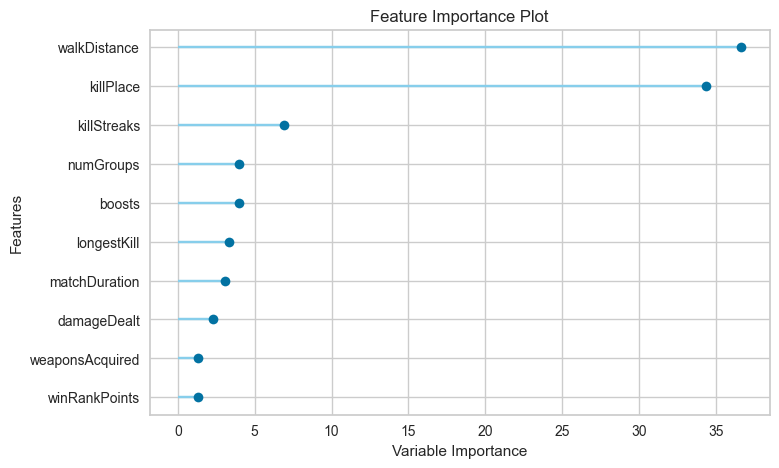

In [38]:
pyr.plot_model(catModel, plot="feature")


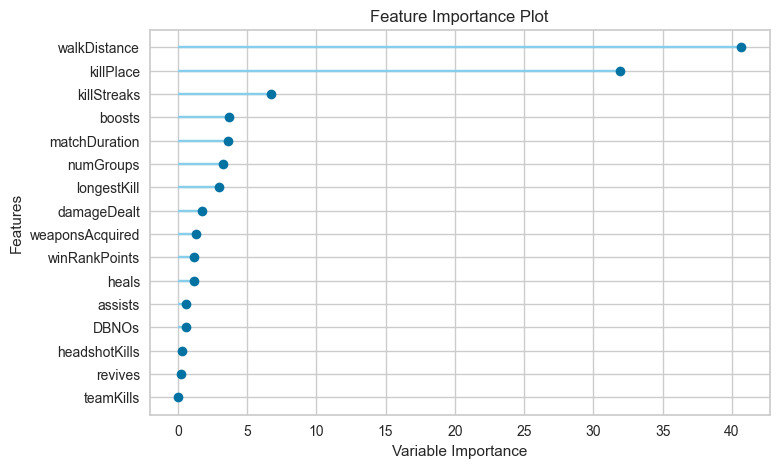

In [37]:
pyr.plot_model(catModel_fpp, plot="feature_all")


In [ ]:
import joblib, os


In [ ]:
model_dir = "./model/"
model_filename = model_dir + "pubg_duo.pkl"
model_fpp_filename = model_dir + "pubg_duo_fpp.pkl"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [ ]:
joblib.dump(catModel, model_filename)


['./model/pubg_duo.pkl']

In [ ]:
joblib.dump(catModel_fpp, model_fpp_filename)


['./model/pubg_duo_fpp.pkl']

In [ ]:
pubg_duoDF_sample.columns


Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killStreaks', 'longestKill', 'matchDuration', 'numGroups',
       'revives', 'teamKills', 'walkDistance', 'weaponsAcquired',
       'winRankPoints', 'winPlacePerc'],
      dtype='object')